In [ ]:
'''
1 - We need the mnist dataset
    its a standard dataset included in keras
    it has 70K 28x28 images of digits from 0 to 9, inclusively

    the train-test split is 6-1 (60k - 10k)

    mnist.load_data() is used to load the training and test set, check docs
'''

from keras.datasets import mnist

(xtrain, ytrain) , (xtest, ytest) = mnist.load_data()

print("Train : ", xtrain.shape, ytrain.shape)
print("test : ", xtest.shape, ytest.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train :  (60000, 28, 28) (60000,)
test :  (10000, 28, 28) (10000,)


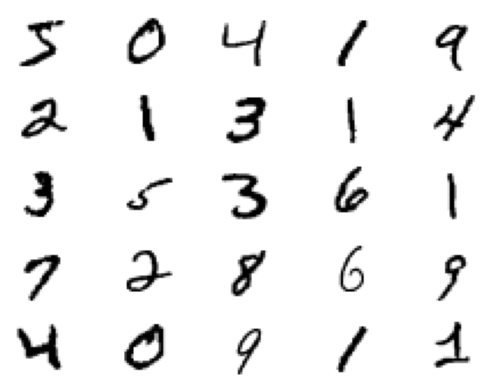

In [ ]:
'''
lets see the images hehe :-D
'''
import matplotlib
import matplotlib.pyplot as plt
from random import randint

for i in range(25):

    plot = plt.subplot(5, 5, i+1)
    plot.axis('off')
    plt.imshow(xtrain[i], cmap = 'gray_r')

In [ ]:
''' 2   let's define a function to make a D
        this D here is small (no pun intended)

        its just two conv layers with leakyrelu and dropout
        followed by a dense sigmoid
'''

from keras import layers as kl
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import plot_model

def make_D(in_shape = (28, 28, 1)):

    model = Sequential([
        kl.Conv2D(64, (3,3), strides = (2,2), padding = 'same', input_shape = in_shape),
        kl.LeakyReLU(alpha = 0.2),
        kl.Dropout(0.4),
        kl.Conv2D(64, (3,3), strides = (2,2), padding = 'same'),
        kl.LeakyReLU(alpha = 0.2),
        kl.Dropout(0.4),
        kl.Flatten(),
        kl.Dense(1, activation = 'sigmoid')
    ])

    opt = Adam(lr = 0.0002, beta_1 = 0.5)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = (['accuracy']))

    return model

#discriminator = make_D()
#discriminator.summary()
#plot_model(discriminator, show_layer_names = True, show_shapes = True)

In [ ]:
'''
lets get the data to train this D

the conv2d expects 3d images but our images are 2d (shape = (28, 28))
so we'll add a dimension to the end (-1 = last)
this will act as a color channel dimension
'''

from keras.datasets import mnist
from numpy import expand_dims

def load_real_samples():

    (Xt, _), (_, _) = mnist.load_data()

    X = expand_dims(Xt, axis = -1)

    X = X.astype('float32')
    X = X / 255.0

    return X

In [ ]:
'''
now a function to get shuffled samples from the dataset as batch labelled as real (= 1)

randint shows a stupid problem on size argument but works fine -_-

note that we are loading the dataset using load_real_samples
and then just taking a shuffled batch from it

'''

from numpy.random import randint
from numpy import ones

def generate_real_samples(dataset, n_samples):

    i = randint(0, dataset.shape[0], n_samples)
    y = ones((n_samples, 1))
    X = dataset[i]
    return X, y

In [ ]:
'''
now for the fake images
we dont have the G yet so we'll just put random values as 28x28 images
'''
from numpy.random import rand
from numpy import zeros

'''
# depricated : made G below and modified this function

def generate_fake_samples(n_samples):

    x = rand(28 * 28 * n_samples)
    x = x.reshape((n_samples, 28, 28, 1))

    y = zeros((n_samples, 1))

    return x, y

'''

In [ ]:
'''
now for training the D we made above
'''

def train_D(model, dataset, iter = 100, batch_size = 256):
    half_batch = int(batch_size / 2)

    for i in range(iter):
        xreal, yreal = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(xreal, yreal)

        xfake, yfake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(xfake, yfake)

        print(f'{i+1} -- {real_acc} -- {fake_acc}')

In [ ]:
'''
let's try this,  discriminator was already made above so we dont need to do that
just the dataset
'''
discr = make_D()
dataset = load_real_samples()
train_D(discr, dataset)

In [ ]:
'''
up next In Sha Allah : The G

the model (for a 28 x 28):

28 --> 14 --> 7
we will first make multiple low resolution represenatations of the 28x28 as 7x7.
say 128, 7x7 outputs from a dense layer

we will use a dense layer to get the inputs using leakyrelu as 128 samples of 7x7. for this we'll use a reshape layer.
then we'll upsample the 7x7 to 14x14 and then to 28x28 using transpose_conv with a (4,4) and strides of (2,2).
the strides being a factor of the kernel size is helpful in doubling the dimensionals while avoiding checkerboard scenarios

the output we'll take from a conv layer with sigmoid activation using a (7,7) kernel.
this will preserve the feature maps and put our values in the desired range [0,1] for grayscale
this is basically condensing the 128 28x28 into 1 single output image
so :

dense        ------->          Conv2DTranspose        -------->        Conv2DTranspose         --------->       Conv2D
in = (7*7*128)
leakyrelu                         leakyrelu                               leakyrelu                             sigmoid
out = (7,7,128)                   out = 14,14,128                         28,28,128                                1

we cant train the generator here. we need to train it with the dicriminator,
so we wont compile it yet
'''

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import LeakyReLU

def make_G(latent_dims):

    n_nodes = 128 * 7 * 7 # 128 images of 7x7
    model = Sequential([

        # reshape input into 7x7 with L_relu
        Dense(n_nodes, input_dim = latent_dims),
        LeakyReLU(alpha = 0.2),
        Reshape((7, 7, 128)),

        # upsample to 14x14 with L_relu
        Conv2DTranspose(128, (4, 4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        # upsample to 28x28 with L_relu
        Conv2DTranspose(128, (4, 4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        # preserve feature map and get output in [0,1]
        Conv2D(1, (7,7),  activation = 'sigmoid', padding = 'same')
    ])

    return model

In [ ]:
'''
lets see how the G looks
'''
from keras.utils import plot_model

G = make_G(100)
G.summary()
plot_model(G, show_layer_names = True, show_shapes = True)

In [ ]:
'''
getting points from latent space

random points, each of 100 dimensions, from a random gaussian distribution
'''

from numpy.random import randn

def generate_latent_points(latent_dims, n_samples):

    X = randn(latent_dims * n_samples)
    X = X.reshape((n_samples, latent_dims))

    return X

In [ ]:
'''
redefine the generate_fake_samples() using the G
'''
from numpy import zeros

def generate_fake_samples(G, latent_dims, n_samples):

    L = generate_latent_points(latent_dims, n_samples)

    X = G.predict(L, verbose = None)

    y = zeros((n_samples, 1))

    return X, y

1/1 [==============================] - 0s 358ms/step
(25, 28, 28, 1)


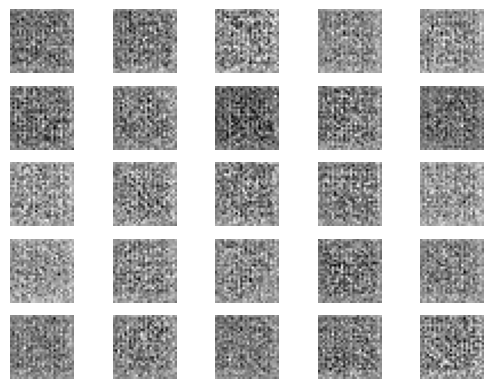

In [ ]:
'''
lets plot some fake samples them,
without training G, yes
'''

import matplotlib.pyplot as plt

l_dims = 100

G = make_G(l_dims)

n = 25
F, _ = generate_fake_samples(G, l_dims, n)

print(F.shape)

for i in range(n):

    plot = plt.subplot(5, 5, i+1)
    plot.axis('off')
    plt.imshow(F[i, :, :, 0], cmap = 'gray_r') # F has shape (25, 28, 28, 1) that is 25 points of 28 rows 28 cols in 1 color channel

    # so picking F[i, :, :, 0] means : i_th point, all its rows, all its cols, its first (0_th) color channel (since their is only one)

In [ ]:
'''
define make GAN using already defined G and D

note that the gan sees D as non trainable
this means when we train the gan, D's loss is used only to update the G
D itself will be trained standalone

if we try to train the D via the gan itself, G and D will oscillate between some two points of loss,
thats now what we need, we instead want the D to keep getting better while making G better
'''

from keras.models import Sequential
from keras.optimizers import Adam

def make_GAN(G, D):

    D.trainable = False

    gan = Sequential()
    gan.add(G)
    gan.add(D)

    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

    gan.compile(loss = 'binary_crossentropy', optimizer = opt)

    return gan

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


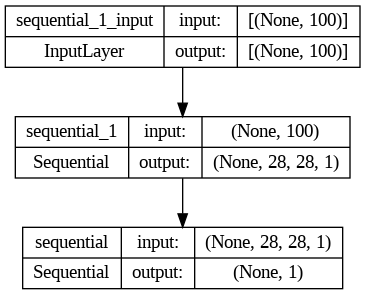

In [ ]:
'''
lets see how the GAN looks :-D
'''

from keras.utils import plot_model

L_dim = 100
Dis = make_D()
Gen = make_G(L_dim)

GAN = make_GAN(Gen, Dis)

GAN.summary()
plot_model(GAN, show_layer_names = True, show_shapes = True)

In [ ]:
'''
Now lets train this bad boy :-]

for training, it is required that we first update the discriminator model with real and fake
samples, then update the generator via the gan model. This requires combining elements
from the train discriminator() function defined in the discriminator section above and the
train gan() function defined above. It also requires that we enumerate over both epochs and
batches within in an epoch.

'''
from numpy import vstack
from numpy import ones

def train_GAN(G, D, GAN, dataset, latent_dim, n_epochs = 100, batch_size = 256):

    batch_p_epoch = dataset.shape[0] // n_epochs
    half_batch = batch_size // 2

    for epoch in range(n_epochs):
        for batch in range(batch_p_epoch):

            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(G, latent_dim, half_batch)

            # stack real and fake samples vertically
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            d_loss, _ = D.train_on_batch(X, y) # we need the verbose we want to monitor the loss

            X_gan = generate_latent_points(latent_dim, batch_size) # not half batch but full, above also we've stacked two half batches to make a full one, albeit with mixed samples

            y_gan = ones((batch_size, 1)) # recall why the shape has to be (batch_size, 1) and not (1, batch_size)? answered below

            g_loss, _ = GAN.train_on_batch(X_gan, y_gan)

            print(f'epoch :{epoch+1} - batch : {batch+1} of {batch_p_epoch} - d_loss : {d_loss} - g_loss : {g_loss}')

            if (i+1) % 10 == 0 :
                summarize_performance(dataset, D, G, epoch, latent_dim) # defined below


In [3]:
'''
evaluation :
'''

def summarize_performance(dataset, D, G, epoch, latent_dim, n_samples = 100):

    X_real, y_real = generate_real_samples(dataset, n_samples)

    _, acc_real = D.evaluate(X_real, y_real, verbose = 0)

    X_fake, y_fake = generate_fake_samples(G, latent_dim, n_samples)

    _, acc_fake = D.evaluate(X_fake, y_fake)

    print(f'{acc_real} -- {acc_fake}')

    save_images(X_fake, epoch) # defined below

    filename = 'gen_plot_%03d.h5' % (epoch+1)
    G.save(filename)

In [4]:
'''
lets also plot and save the images generated in the epoch
and put this in the summarize_performance above
'''
import matplotlib.pyplot as plt

def save_images(examples, epoch, n = 10):

    for i in range(n * n):

        ax = plt.subplot(n, n, i + 1)
        ax.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap = 'gray')

    filename = 'gen_plot_%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [ ]:
'''
lets put all this together in a separate file now
'''